In [288]:
from pathlib import Path
import datetime
import numpy as np
import pandas as pd
from matplotlib import pylab as plt
from pymongo import MongoClient

# Load data
Step 0 is pulling events with the Sentry API

In [2]:
def load_event(event_name, unique=True):
    db = MongoClient().fmriprep_stats
    data = pd.DataFrame(list(db[event_name].find()))
    
    if len(data) == 0:
        raise RuntimeError(f"No records of event '{event_name}'")
    data.dateCreated = pd.to_datetime(data.dateCreated)
    data["date_minus_time"] = data["dateCreated"].apply(
        lambda df: datetime.datetime(year=df.year, month=df.month, day=df.day)
    )
    if unique is True:
        return data.drop_duplicates(subset=['run_uuid'])
    return data

## Processing "started" event

In [3]:
unique_started = load_event("started")
grouped_started = unique_started.groupby([
    unique_started['date_minus_time'].dt.isocalendar().year,
    unique_started['date_minus_time'].dt.isocalendar().week,
])['id'].count()
grouped_started

year  week
2022  36       1181
      37       7276
      38       5302
      39       8507
      40       5774
      41       7273
      42       6472
      43       6744
      44       7336
      45       7588
      46      10381
      47       7658
      48       8155
      49       8925
      50       7722
      51       8864
      52       5191
2023  1        4121
      2        7972
      3        8513
      4       16016
      5       16226
      6        9072
      7       10386
      8       11161
      9        8333
      10      14707
      11       8517
      12      12679
      13      13038
      14      10584
      15      13700
      16      11535
      17      10974
      18       9827
      19       7646
      20       8344
      21       7494
      22       8343
      23       9141
      24        393
Name: id, dtype: int64

## Processing "success" event

In [4]:
unique_success = load_event("success")
grouped_success = unique_success.groupby([
    unique_success['date_minus_time'].dt.isocalendar().year,
    unique_success['date_minus_time'].dt.isocalendar().week,
])['id'].count()
grouped_success

year  week
2022  36        672
      37       4709
      38       4004
      39       5765
      40       4237
      41       4909
      42       4442
      43       4352
      44       4904
      45       5026
      46       8420
      47       5877
      48       6184
      49       6591
      50       4902
      51       6715
      52       3824
2023  1        2956
      2        4840
      3        6085
      4       14232
      5       13276
      6        6637
      7        7495
      8        8062
      9        5829
      10      11685
      11       6055
      12       9936
      13       9820
      14       7492
      15      10804
      16       8699
      17       8132
      18       7633
      19       5554
      20       5738
      21       5492
      22       5466
      23       6305
      24        621
Name: id, dtype: int64

In [5]:
unique_started_success = unique_success.loc[unique_success['run_uuid'].isin(unique_started['run_uuid'])]
grouped_started_success = unique_started_success.groupby([
    unique_started_success['date_minus_time'].dt.isocalendar().year,
    unique_started_success['date_minus_time'].dt.isocalendar().week,
])['id'].count()

In [344]:
month_starts, x_ticks, x_ticks_labels, month_starts[:-1] + 0.5*(month_starts[1:] - month_starts[:-1]),  0.5*(month_starts[1:] + month_starts[:-1])

(array([ 0,  3,  8, 12, 16, 21, 25, 29, 33, 38]),
 array([ 2.,  6., 10., 14., 18., 23., 27., 31., 36.]),
 ['Sep', 'Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May'],
 array([ 1.5,  5.5, 10. , 14. , 18.5, 23. , 27. , 31. , 35.5]),
 array([ 1.5,  5.5, 10. , 14. , 18.5, 23. , 27. , 31. , 35.5]))

## Successful runs per week

<Figure size 432x288 with 0 Axes>

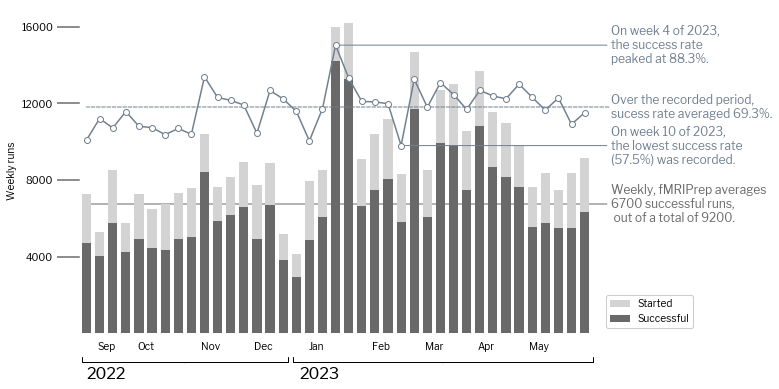

In [357]:
plt.clf()

plt.rcParams["font.family"] = "Libre Franklin"


fig,ax = plt.subplots(figsize=(10, 6))

indexes = grouped_started.index[1:-1]
x = np.arange(len(grouped_success.values[1:-1]), dtype=float)

bar1 = ax.bar(x, grouped_started.values[1:-1], width=0.7, label='Started', color="lightgrey")
bar2 = ax.bar(x, grouped_success.values[1:-1], width=0.7, label='Successful', color="dimgrey")

yticks = [4000, 8000, 12000, 16000]
for line in yticks:
    ax.axhline(
        line,
        xmin=0,
        xmax=0.04,
        color="dimgrey",
        zorder=0.0,
    )

monthnames = [
    datetime.date.fromisocalendar(year, week, 1).strftime("%b")
    for year, week in indexes
]

month_starts = np.array(sorted(
    [monthnames.index(m) for m in set(monthnames)]
))

x_ticks = month_starts + 1.5
x_ticks_labels = [monthnames[x] for x in month_starts]

ax.set_xticks(x_ticks[:-1], labels=x_ticks_labels[:-1])
ax.xaxis.set_tick_params(length=0)

ax.set_yticks(yticks, labels=yticks)
ax.yaxis.set_tick_params(length=0)

ax.set_ylabel("Weekly runs")
ax.legend(loc='lower right', bbox_to_anchor=(1.15, 0.), framealpha=1, mode=None);

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['bottom'].set_position(('outward', 5))

trans = ax.get_xaxis_transform()
ax.annotate(
    "",
    xy=(7.5, -.09),
    xytext=(7.5, -.097),
    arrowprops={"arrowstyle": "-[, widthB=10.3, lengthB=0.5, angleB=0"},
    xycoords=trans,
    annotation_clip=False,
)

ax.annotate(
    "2022",
    xy=(0, -.14),
    xytext=(0, -.14),
    xycoords=trans,
    annotation_clip=False,
    size=16,
    horizontalalignment="left",
)

ax.annotate(
    "",
    xy=(27.2, -.09),
    xytext=(27.2, -.097),
    arrowprops={"arrowstyle": "-[, widthB=15, lengthB=0.5, angleB=0"},
    xycoords=trans,
    annotation_clip=False,
)

ax.annotate(
    "2023",
    xy=(16.2, -.14),
    xytext=(16.2, -.14),
    xycoords=trans,
    annotation_clip=False,
    size=16,
    horizontalalignment="left",
)


abs_success_mean = grouped_success.values[1:-1].mean()
ax.annotate(
    "Weekly, fMRIPrep averages\n"
    f"{int(round(abs_success_mean, -2))} successful runs,"
    "\n"
    f" out of a total of {int(round(grouped_started.values[1:-1].mean(), -2))}.",
    xy=(0, abs_success_mean),
    xytext=(len(success_ratio) + 1, abs_success_mean),
    xycoords="data",
    annotation_clip=False,
    color="dimgrey",
    size=12,
    horizontalalignment="left",
    verticalalignment="center",
    arrowprops={"arrowstyle": "-", "color": "dimgrey"},
).set_zorder(-0.5)

success_ratio = 100 * grouped_started_success.values[1:-1] / grouped_started.values[1:-1]
success_mean = success_ratio.mean()

ax2 = ax.twinx()

max_success = (np.argmax(success_ratio), success_ratio.max())
max_date = indexes[max_success[0]]
min_success = (np.argmin(success_ratio), success_ratio.min())
min_date = indexes[1:-1][min_success[0]]

ax2.annotate(
    "Over the recorded period,\n"
    f"sucess rate averaged {round(success_mean, 1)}%.",
    xy=(0, success_mean),
    xytext=(len(success_ratio) + 1, success_mean),
    xycoords="data",
    annotation_clip=False,
    color="slategray",
    size=12,
    horizontalalignment="left",
    verticalalignment="center",
    arrowprops={"arrowstyle": "-", "color": "slategray",  "linestyle" : "--", "shrinkA": 0, "shrinkB": 0},
).set_zorder(-0.5)

ax2.annotate(
    f"On week {max_date[1]} of {max_date[0]},"
    "\nthe success rate\npeaked at "
    f"{round(max_success[1], 1)}%.",
    xy=(max_success[0], round(max_success[1], 1)),
    xytext=(len(success_ratio) + 1, round(max_success[1], 1)),
    xycoords="data",
    annotation_clip=False,
    color="slategray",
    size=12,
    arrowprops={"arrowstyle": "-", "color": "slategray"},
    horizontalalignment="left",
    verticalalignment="center"
)

ax2.annotate(
    f"On week {min_date[1]} of {min_date[0]},"
    "\nthe lowest success rate \n"
    f"({round(min_success[1], 1)}%) was recorded.",
    xy=(min_success[0], round(min_success[1], 1)),
    xytext=(len(success_ratio) + 1, round(min_success[1], 1)),
    xycoords="data",
    annotation_clip=False,
    color="slategray",
    size=12,
    arrowprops={"arrowstyle": "-", "color": "slategray"},
    horizontalalignment="left",
    verticalalignment="center"
)


ax2.plot((grouped_started_success.values[1:-1] / grouped_started.values[1:-1]) * 100, 'o-', color="slategray", mfc="white", zorder=4)
ax2.set_ylim(0, 100)
ax2.set_yticks([])

ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines['bottom'].set_visible(False)

#plt.ylabel("Success rate (%)")


plt.savefig('20221206_successful_weekly_abs.png', dpi=300, bbox_inches='tight', facecolor="white")

NameError: name 'indexes' is not defined

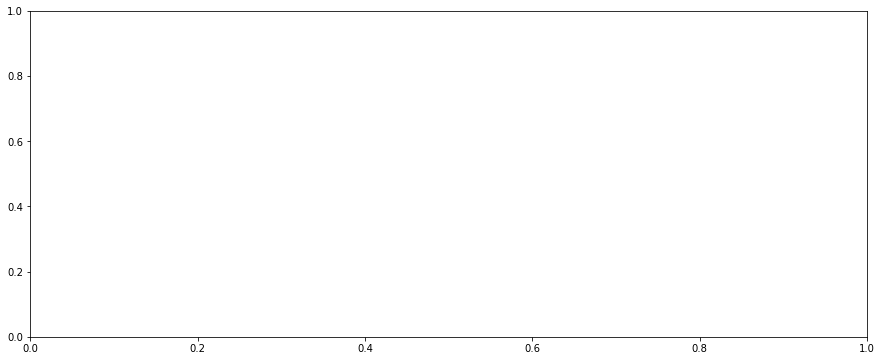

In [121]:
fig,ax = plt.subplots(figsize=(15, 6))
ax.bar(indexes, (grouped_started_success.values[:-1] / grouped_started.values[:-1]) * 100,
       width=0.9, label='Success')

plt.ylabel("Percentage of successful runs")
plt.xlabel("Week of year (2022)")
plt.title("Successful fMRIPrep runs per week (all versions)")
ax.set_ylim((0,100))
plt.legend(bbox_to_anchor=(1, 1), title='Events');
plt.savefig('20221206_successful_weekly_rel.png', dpi=300, bbox_inches='tight')

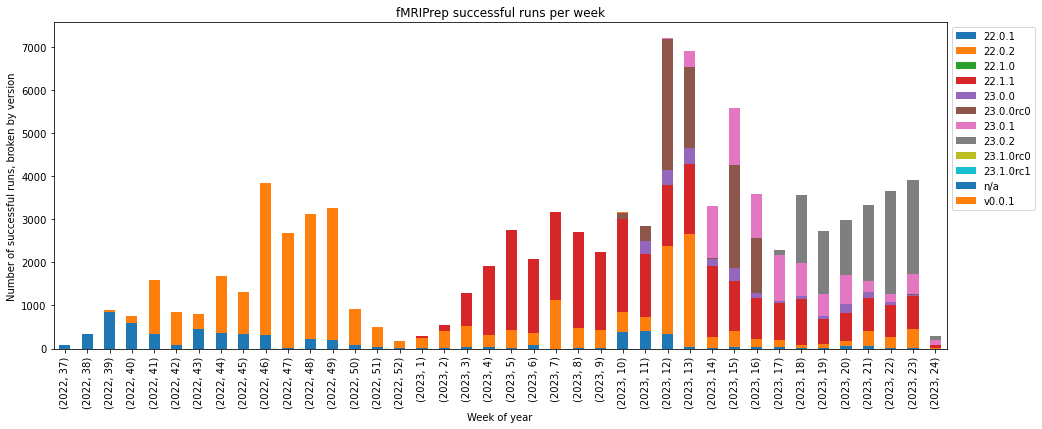

In [11]:
fig,ax = plt.subplots(figsize=(16,6))
ax = versions_success.plot.bar(stacked=True, ax=ax)

plt.ylabel("Number of successful runs, broken by version")
plt.xlabel("Week of year")
plt.title("fMRIPrep successful runs per week")
plt.legend(bbox_to_anchor=(1, 1));
plt.savefig('20221206_version_successful_weekly_abs.png', dpi=300, bbox_inches='tight')

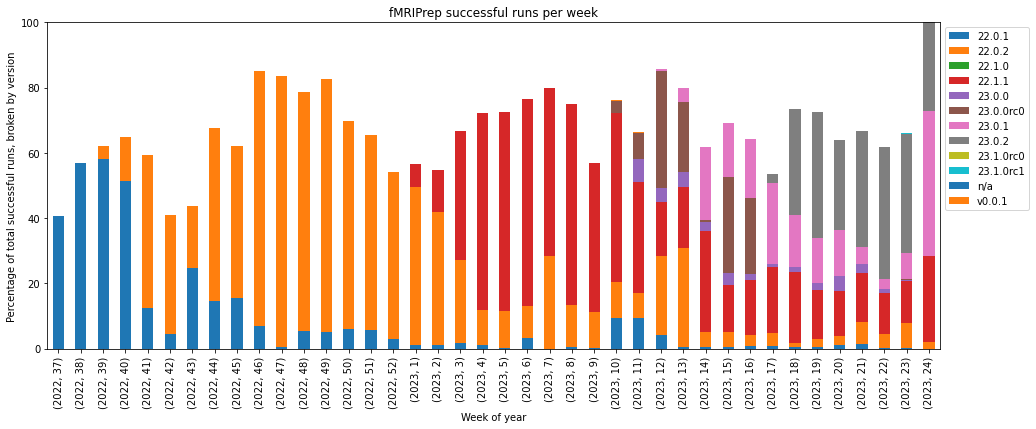

In [12]:
fig,ax = plt.subplots(figsize=(16,6))
ax = ((versions_success.T / versions_started.sum(axis=1)).T * 100).plot.bar(stacked=True, ax=ax)

ax.set_ylim((0,100))
plt.ylabel("Percentage of total successful runs, broken by version")
plt.xlabel("Week of year")
plt.title("fMRIPrep successful runs per week")
plt.legend(bbox_to_anchor=(1, 1));
plt.savefig('20221206_version_successful_weekly_rel_total.png', dpi=300, bbox_inches='tight')

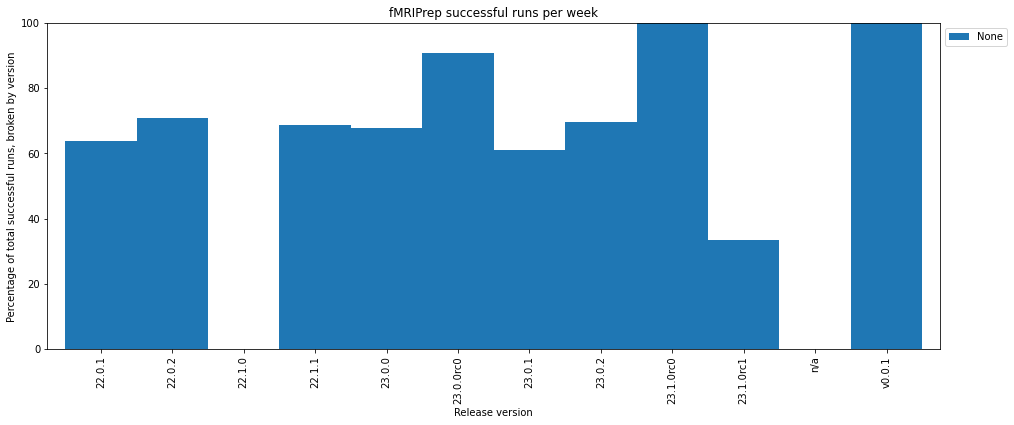

In [13]:
fig,ax = plt.subplots(figsize=(16,6))
ax = ((versions_success.sum(axis=0) / versions_started.sum(axis=0)) * 100).plot.bar(ax=ax, width=1.0)

ax.set_ylim((0,100))

plt.ylabel("Percentage of total successful runs, broken by version")
plt.xlabel("Release version")
plt.title("fMRIPrep successful runs per week")
plt.legend(bbox_to_anchor=(1, 1));
plt.savefig('20221206_version_successful_weekly_rel_broken.png', dpi=300, bbox_inches='tight')

In [14]:
versions_success.sum(axis=0)

22.0.1        5993.0
22.0.2       30356.0
22.1.0           0.0
22.1.1       28516.0
23.0.0        2215.0
23.0.0rc0     9139.0
23.0.1        8003.0
23.0.2       10870.0
23.1.0rc0        1.0
23.1.0rc1        2.0
n/a              0.0
v0.0.1          25.0
dtype: float64

In [15]:
versions_started.sum(axis=0)

22.0.1        9374.0
22.0.2       42772.0
22.1.0           9.0
22.1.1       41602.0
23.0.0        3271.0
23.0.0rc0    10077.0
23.0.1       13084.0
23.0.2       15639.0
23.1.0rc0        1.0
23.1.0rc1        6.0
n/a              0.0
v0.0.1          25.0
dtype: float64